<a href="https://colab.research.google.com/github/Mahrokh-Eb/Deep-Learning-with-Python/blob/main/plantSeed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/plantSeed

/content/drive/MyDrive/plantSeed


In [3]:
#!pip3 install bcolz

     |████████████████████████████████| 1.5MB 5.1MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp37-cp37m-linux_x86_64.whl size=2641436 sha256=d1d70676b429b9665ad5352414b2b566eb393139dda9297e82b68022b6c4e951
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz


In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

In [5]:
#pip install kaggle

In [6]:
use_gpu

False

In [7]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/plantSeed/drive"

In [8]:
%cd /content/drive/MyDrive/plantSeed/drive/

/content/drive/MyDrive/plantSeed/drive


In [9]:
pwd

'/content/drive/My Drive/plantSeed/drive'

In [10]:
'''!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6'''

'!pip uninstall -y kaggle\n!pip install --upgrade pip\n!pip install kaggle==1.5.6'

In [11]:
#!kaggle competitions download -c plant-seedlings-classification

In [12]:
#!ls

In [13]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

In [14]:
DATA_DIR ='/content/drive/MyDrive/plantSeed/drive/'

sz = 224
batch_size = 16

In [15]:
#os.listdir(DATA_DIR)

In [16]:
trn_dir = f'{DATA_DIR}train'
test_dir = f'{DATA_DIR}test'

In [17]:
trn_fnames = glob.glob(f'{DATA_DIR}/*/*')
trn_fnames[:5]

['/content/drive/MyDrive/plantSeed/drive/test/003d61042.png',
 '/content/drive/MyDrive/plantSeed/drive/test/007b3da8b.png',
 '/content/drive/MyDrive/plantSeed/drive/test/0021e90e4.png',
 '/content/drive/MyDrive/plantSeed/drive/test/0086a6340.png',
 '/content/drive/MyDrive/plantSeed/drive/test/00c47e980.png']

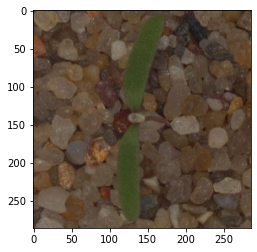

In [18]:
img = plt.imread(trn_fnames[715])
plt.imshow(img);

#Dataset

In [19]:
train_ds = datasets.ImageFolder(trn_dir)

In [20]:
train_ds.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [21]:
train_ds.class_to_idx

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [22]:
train_ds.root

'/content/drive/MyDrive/plantSeed/drive/train'

In [23]:
train_ds.imgs[:3]

[('/content/drive/MyDrive/plantSeed/drive/train/Black-grass/0050f38b3.png', 0),
 ('/content/drive/MyDrive/plantSeed/drive/train/Black-grass/0183fdf68.png', 0),
 ('/content/drive/MyDrive/plantSeed/drive/train/Black-grass/0260cffa8.png', 0)]

#Transforms

In [24]:
tfms = transforms.Compose([transforms.Resize((sz, sz)), 
                          transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.244, 0.225])
                          ])
train_ds = datasets.ImageFolder(trn_dir, tfms)
#valid_ds = datasets.ImageFolder(X_val, tfms)


#Dataloader

In [25]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


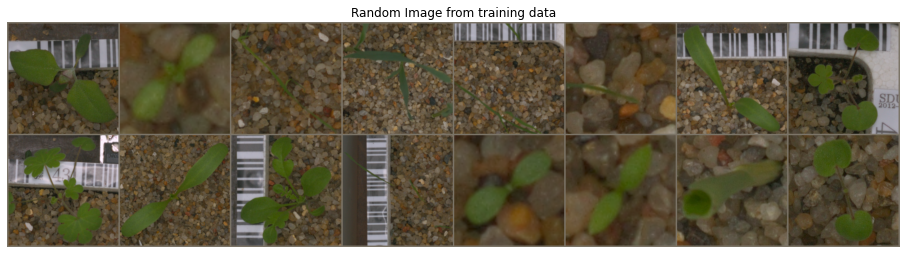

In [26]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16,12))
imshow(out, title='Random Image from training data')

#Model: CNN

In [27]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
                nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(56* 56* 32, 12)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [28]:
CUDA_LAUNCH_BLOCKING=1

In [29]:
model = SimpleCNN()

if use_gpu:
    model = model.cuda()

#Loss Function and Optimizer¶

In [32]:
criterian = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

#Train

In [ ]:
num_epochs = 20
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = to_var(inputs)
        targets = to_var(targets)
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # loss
        loss = criterian(outputs, targets)
        losses += [loss.data]
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.data))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [ 1/10], Step [ 50/296], Loss: 2.5744
Epoch [ 1/10], Step [100/296], Loss: 2.4269
Epoch [ 1/10], Step [150/296], Loss: 2.4341


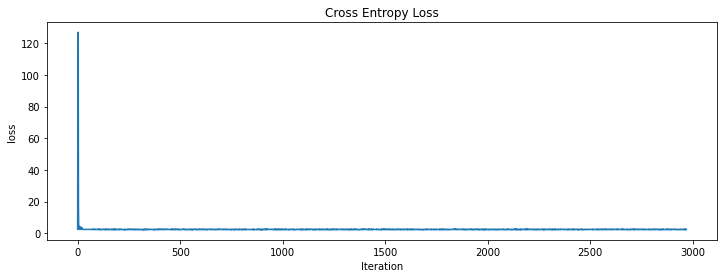

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');

In [36]:
def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [38]:
evaluate_model(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/MyDrive/plantSeed/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 13.77


In [ ]:
visualize_model(model, train_dl)

In [ ]:
y_pred, y_true = predict_class(model, valid_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))